## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants
import seaborn as sns
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits
import pickle   

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [3]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
# simbad: https://simbad.cds.unistra.fr/simbad/sim-id?Ident=toi+4438&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id
TIC_ID = 22233480

epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
duration_tess = ufloat(2.0033137761697, 0.15890975)

depth_tess = ufloat(4045.7241784744, 128.28719)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149
stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)
stteff_tess = ufloat(3353, 157)
gaia_teff = 3183.4  # gaia dr3
pub_teff =  ufloat(3422, 81) 
pub_rad = ufloat(0.372, 0.018)
pub_mass = ufloat(0.368, 0.021)

stteff = ufloat(3501, 70)
strad = ufloat(0.355, 0.014)
stmass = ufloat(0.350, 0.018)
star_name = 'TOI-4438'

# our parameters from Spirou spectra analysis
par = pd.read_table('./data/stellar_params.dat', sep=None, engine='python', header=0, skiprows=1)
par

,star,teff,teff_err,logg,logg_err,M/H,M/H_err,alpha,alpha_err,vmic,vmic_err,L,L_err,R,R_err,M,M_err
0,TOI-442,4123.3,43.68,4.60,0.08,0.05,0.1,0.13,0.10,1.05,0.34,0.07500,0.00100,0.536,0.012,0.542,0.001
1,TOI-4438,3501.0,70.01,4.67,0.11,0.07,0.1,-0.08,0.08,2.35,0.42,0.01706,0.00007,0.355,0.014,0.350,0.018


## Read LCs

In [4]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

# tpf_search = lk.search_targetpixelfile('TIC 22233480')
# tpf_search

In [5]:
# search = lk.search_lightcurve('TIC 22233480')
# search

In [ ]:
# download lightcurves
#lc_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53]).download_all(flux_column="pdcsap_flux")
# lc_79_80_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=79, exptime=120).download_all(flux_column="pdcsap_flux")

# these are the ones we will use
# lc_79_80_fast_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79, 80], exptime=20).download_all(flux_column="pdcsap_flux")
# lc_short_all_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53, 79, 80]).download_all(flux_column="pdcsap_flux")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

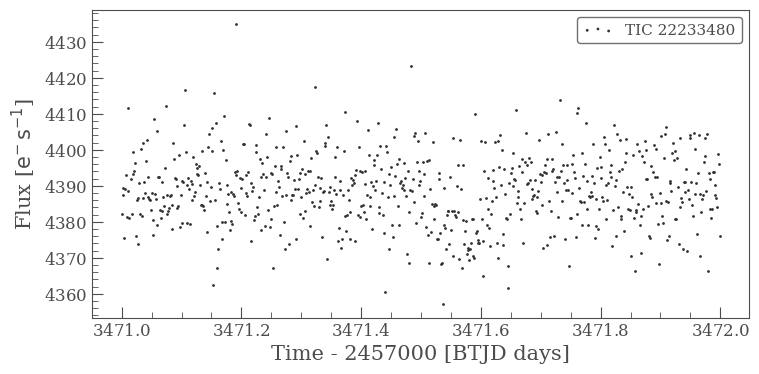

In [ ]:
# lc_79_80_short_file[0][(lc_79_80_short_file[0]['time'].value>3471.0)&(lc_79_80_short_file[0]['time'].value<3472.0)].scatter()

In [85]:
np.sum(lc_79_80_short_file[0]['quality'].value==512)

1

In [71]:
lc_79_80_short_file[0]['time'].value>0

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
# check sap flux

#sap_79_80 = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79, 80], exptime=120).download_all(flux_column="sap_flux")
#sap_79_80.stitch().scatter()

In [8]:
# check sap flux

#sap_52_53 = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[52, 53], exptime=120).download_all(flux_column="sap_flux")
#sap_52_53.stitch().scatter()

In [9]:
#sap_79_80.stitch().scatter()

In [10]:
#lc_short = lc_short_file.stitch().remove_nans().normalize().remove_outliers()
#lc_79_80_fast_bin = lc_79_80_fast.bin(time_bin_size=120*u.s.to(u.day)).remove_nans()
#lc_79_80_short = lc_79_80_short_file.stitch().remove_nans().normalize().remove_outliers()

In [11]:
# this are the ones to save, first normalize 

# lc_79_80_fast = lc_79_80_fast_file.stitch().remove_nans().normalize().remove_outliers()
# lc_short_all = lc_short_all_file.stitch().remove_nans().normalize().remove_outliers()
# lc_short_all.to_csv('./data/toi4438/lc_short_all.csv')
# lc_79_80_fast.to_csv('./data/toi4438/lc_79_80_fast.csv')

In [12]:
# read the saved lightcurves

read_file1 = pd.read_csv('./data/toi4438/lc_short_all.csv')
lc_short_all = lk.LightCurve(time=read_file1['time'], flux=read_file1['flux'], flux_err=read_file1['flux_err'])
read_file2 = pd.read_csv('./data/toi4438/lc_79_80_fast.csv')
lc_79_80_fast = lk.LightCurve(time=read_file2['time'], flux=read_file2['flux'], flux_err=read_file2['flux_err'])

<Axes: xlabel='Time [JD]', ylabel='Flux'>

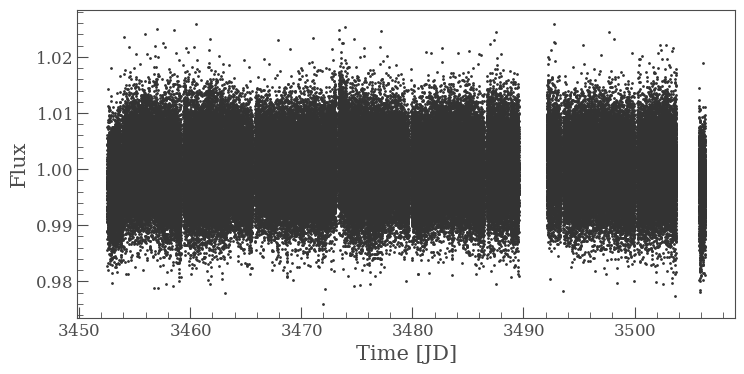

In [13]:
# plot sector 79 fast cadence
lc_79_80_fast.scatter()

In [14]:
# # sector 79 and 80 fast cadence
# fig, ax = plt.subplots(3, 1, figsize=(6,6), dpi=150, sharex=True, sharey=True)
# fig.subplots_adjust(hspace=0, wspace=0)
# lc_79_80_short.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[0], c='k', label='')
# lc_79_80_fast.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[1], c='k', label='')
# lc_79_80_fast_bin.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[2], c='k', label='')
# ax[0].text(0.05, 0.9, 'Cadencia 120s', transform=ax[0].transAxes)
# ax[1].text(0.05, 0.9, 'Cadencia 20s', transform=ax[1].transAxes)
# ax[2].text(0.05, 0.9, 'Cadencia 20s Bineado a 120s', transform=ax[2].transAxes)
# ax[0].set_title('Sector 79 y 80')
# ax[0].set_ylabel('Normalized flux')
# ax[0].set_xlabel('Phase')
# plt.xlim(-0.5, 0.5)

### Asteroseismology?

In [15]:
# seism = lc_79_80_fast_bin.to_periodogram(normalization='psd')
# ax = seism.plot()
# #plt.xlim(500, 3500)
# plt.ylim(0, 5e-8)

### LC to use

In [16]:
# for the model, short and fast cadence binned to short are concatenated 
time = np.asarray(lc_short_all.time.value)
flux = np.asarray(lc_short_all.flux.value)
flux_err = np.asarray(lc_short_all.flux_err.value)

# all sectors with 120s cadence
inds2 = np.argsort(time)
time = np.ascontiguousarray(time[inds2], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds2], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds2], dtype=np.float64)

# all sectors binned to 5 minutes for faster computation, 79 from 20s
# bin to 5 minutes and save to disk

#lc_short_5min = lc_short_all.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
#lc_short_5min.to_csv('./data/toi4438/lc_short_all_5min.csv')

# read the saved lightcurve
read_file3 = pd.read_csv('./data/toi4438/lc_short_all_5min.csv')
lc_short_5min = lk.LightCurve(time=read_file3['time'], flux=read_file3['flux'], flux_err=read_file3['flux_err'])

time5 = np.asarray(lc_short_5min.time.value)
flux5 = np.asarray(lc_short_5min.flux.value)
flux_err5 = np.asarray(lc_short_5min.flux_err.value)

# all sectors with 300s cadence
inds5 = np.argsort(time5)
time_5min = np.ascontiguousarray(time5[inds5], dtype=np.float64)
flux_5min = np.ascontiguousarray(flux5[inds5], dtype=np.float64)
flux_err_5min = np.ascontiguousarray(flux_err5[inds5], dtype=np.float64)

# get the exptimes
texp = 2.0 / 60.0 / 24.0
texp_binned = 5.0 / 60.0 / 24.0

ref_time = np.min(time)

In [17]:
# we're gonna split the lightcurves in 3 parts, sector 40, sector 52-53, and sector 79-80
# lets creat another variable to store the sector of each point, then the sector ID will be 0, 1, 2. 
# same as we did with different instruments in RVs
# sector 40 -> time < 2600
# sector 52-53 -> 2600 < time < 3000
# sector 79-80 -> time > 3000

# 2min cadence
sector_id = np.zeros(len(time), dtype=int)
sector_id[time > 2600] = 1
sector_id[time > 3000] = 2

# 5min cadence
sector_id_5min = np.zeros(len(time_5min), dtype=int)
sector_id_5min[time_5min > 2600] = 1
sector_id_5min[time_5min > 3000] = 2

sector_id_names = ['Sector_40', 'Sector_52_53', 'Sector_79_80']

### TLS analysis

In [18]:
from transitleastsquares import transit_mask

In [19]:
# load the results from the TLS
with open('./results/tls/tls_complete_4438.pkl', 'rb') as f:
    results = pickle.load(f)

In [20]:
print(results['period'], results['T0'], results['duration'], results['depth'], results['SDE'])
tls_p = results['period']
tls_t0 = results['T0']
tls_duration = results['duration']
tls_depth = results['depth']

7.44638938696153 2396.4028181911876 0.009639058707696555 0.9962119993941828 59.23046574631713


### Transit masks

In [21]:
tls_duration*24

0.23133740898471733

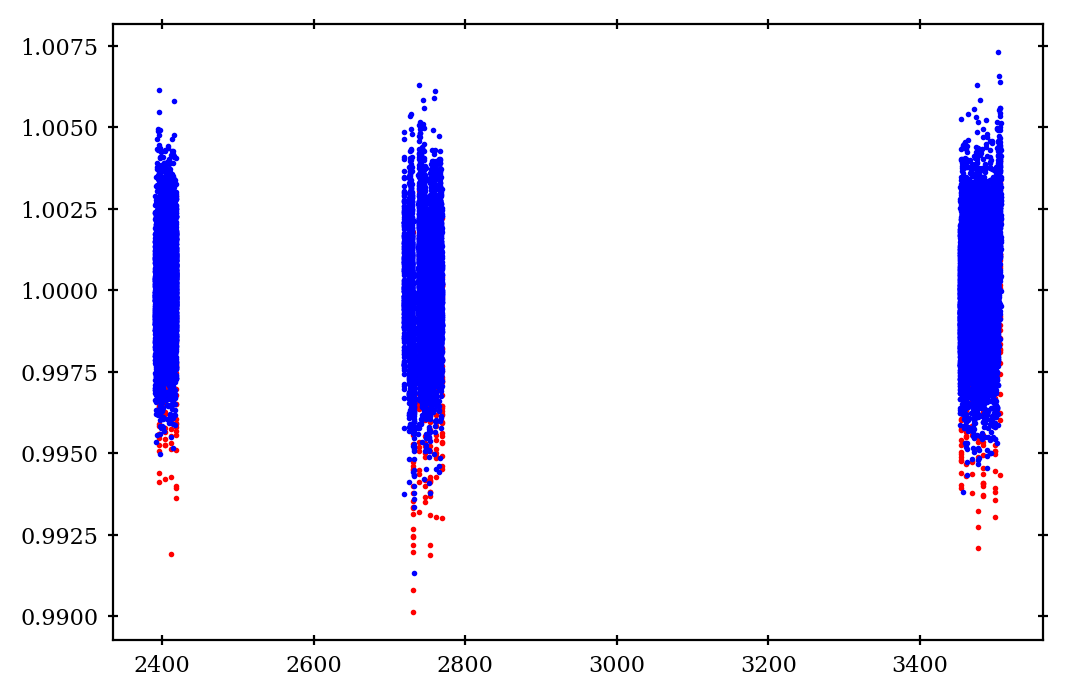

In [22]:
intransit_5min = transit_mask(time_5min, tls_p, 1, tls_t0) # 1 day around the transits for faster modeling
intransit = transit_mask(time, tls_p, 1, tls_t0)
# just the transits 5min
intransit_5min_small = transit_mask(time_5min, tls_p, tls_duration*12, tls_t0) # only the transits
intransit_small = transit_mask(time, tls_p, tls_duration*12, tls_t0)
# just the transits 120s
in_transit = transit_mask(time, tls_p, tls_duration*12, tls_t0)

# plt.scatter(time_5min[intransit_5min], flux_5min[intransit_5min], s=1, color='red')  # in-transit points in red
# plt.scatter(time_5min[~intransit_5min], flux_5min[~intransit_5min], s=1, color='blue')  # other points in blue
plt.scatter(time_5min[intransit_5min_small], flux_5min[intransit_5min_small], s=1, color='red')  # in-transit points in red
plt.scatter(time_5min[~intransit_5min_small], flux_5min[~intransit_5min_small], s=1, color='blue')  # other points in blue
#plt.xlim(2410, 2412)
#plt.xlim(3482, 3484)

Text(0.95, 0.92, 'Max power = 7.4464 d')

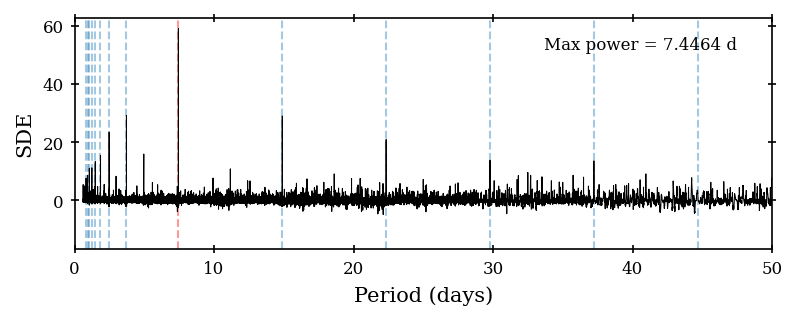

In [23]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)
plt.xlim(np.min(results['periods']), np.max(results['periods']))
ax.axvline(tls_p, alpha=0.4, lw=1, linestyle="dashed", color='red')
for n in range(2, 10):
    ax.axvline(n*tls_p, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(tls_p/ n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results['periods'], results['power'], color='black', lw=0.5)
plt.xlim(0, max(results['periods']))
plt.xlim(0, 50)
plt.text(.95, .92, 'Max power = {k:.4f} d'.format(k=tls_p), fontsize=8, 
         ha='right', va='top', transform=ax.transAxes)
#plt.ylim(0, 100)
#plt.savefig(f'./plots/toi4438/tls1-{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

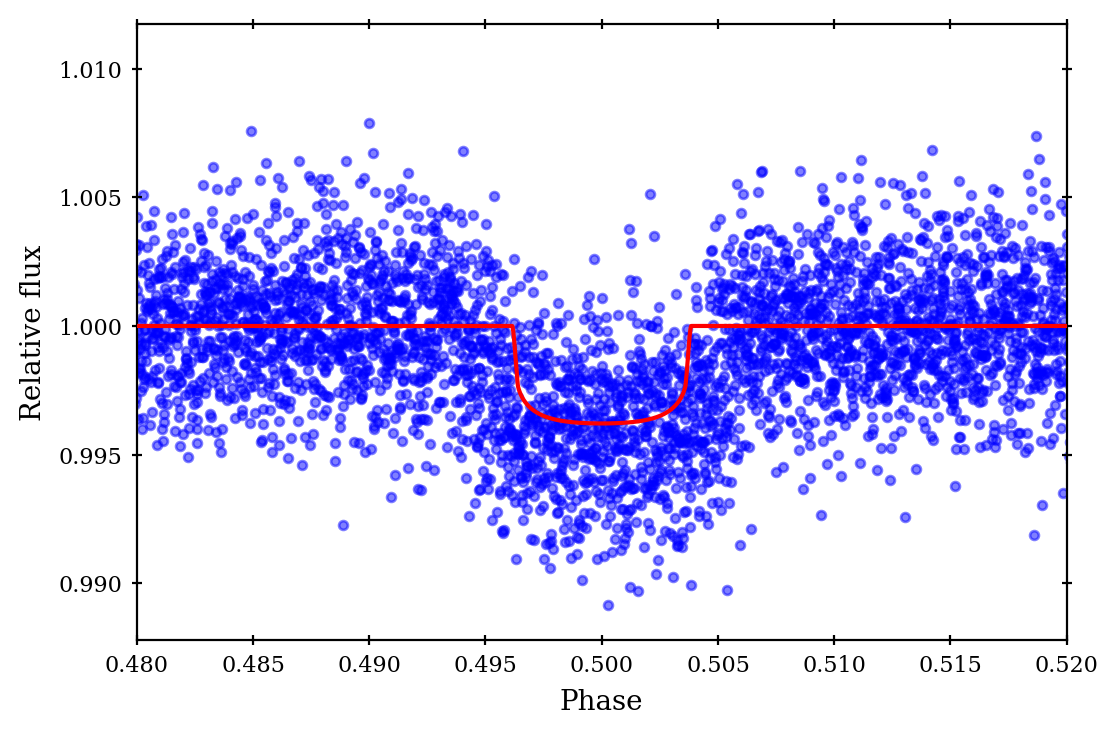

In [24]:
# results phase folded
plt.figure()
plt.plot(results['model_folded_phase'], results['model_folded_model'], color='red', zorder=10)
plt.scatter(results['folded_phase'], results['folded_y'], color='blue', s=10, alpha=0.5)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [25]:
tls_duration*10

0.09639058707696554

In [26]:
duration_tess/24

0.08347140734040416+/-0.006621239583333332

(2725.0, 2745.0)

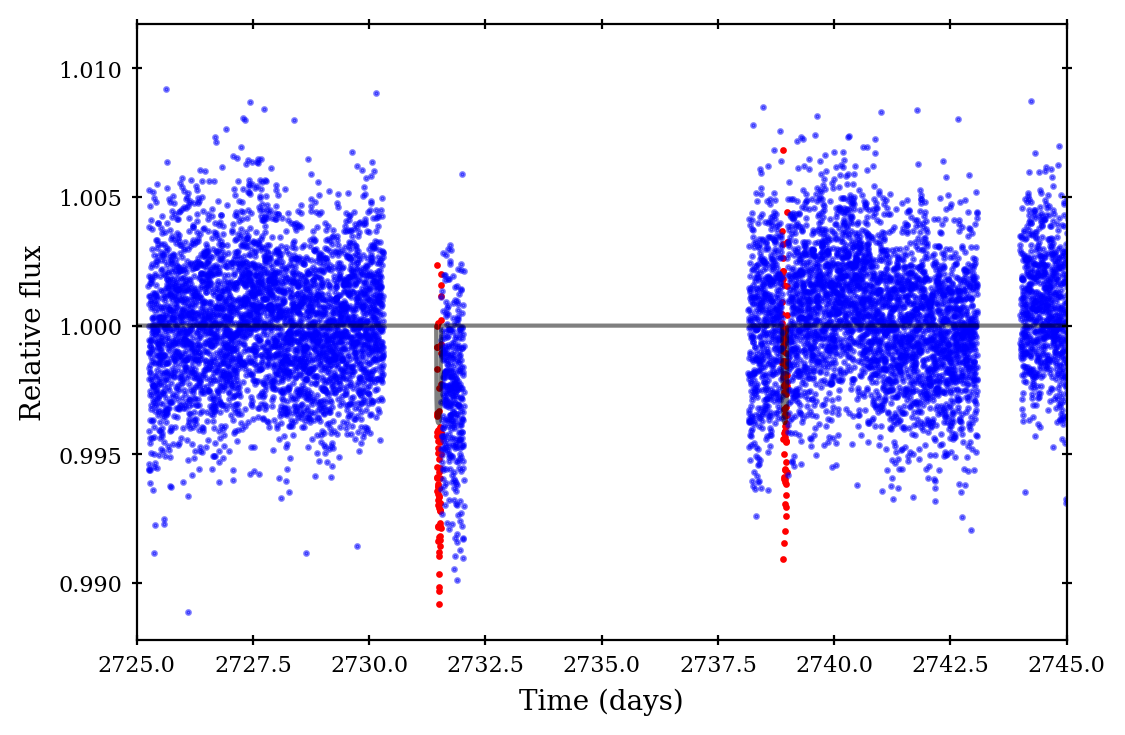

In [27]:
# complete light curve with no transits
plt.figure()
plt.scatter(time[in_transit], flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(time[~in_transit], flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results['model_lightcurve_time'], results['model_lightcurve_model'], alpha=0.5, color='k', zorder=1)
plt.xlim(time.min(), time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(2418,2420)
plt.xlim(2725,2745)

Period 7.44639 d at T0= 2396.4028181911876
The number of transits with intransit data points 17
The number of transits with no intransit data points 133
Transit depth 0.99621 (at the transit bottom)
Transit duration (hours) 0.23134
Transit depths (mean) 3.875782092412128 ppt


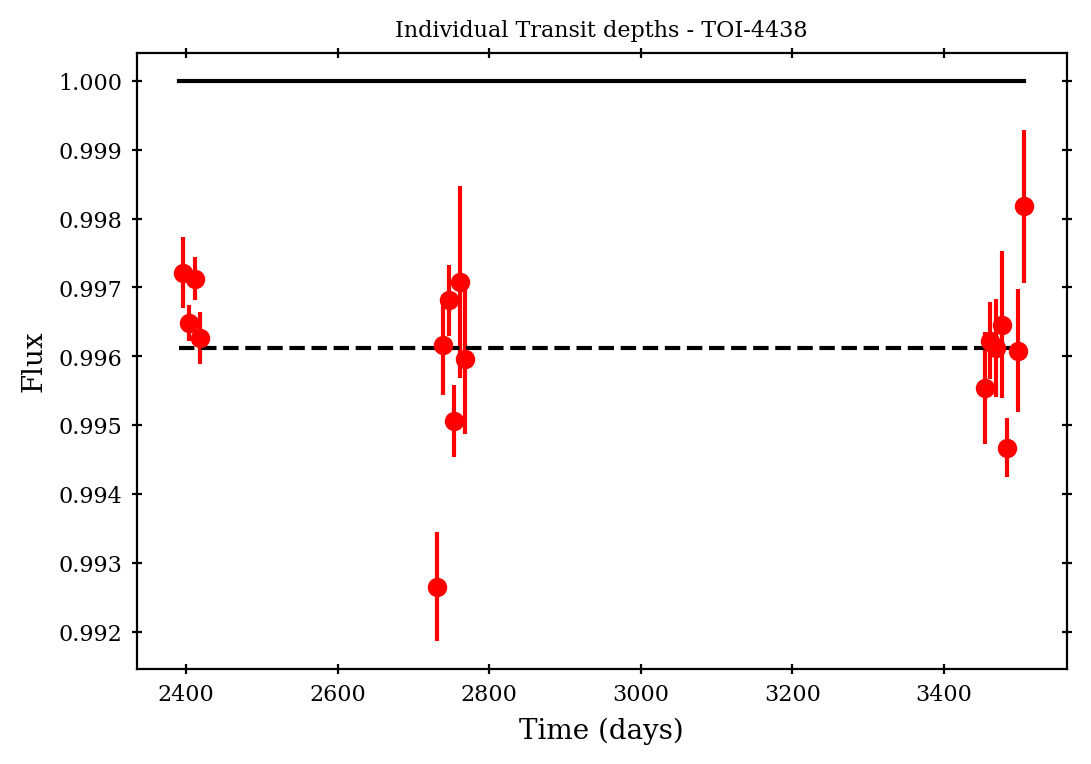

In [28]:
print('Period', format(tls_p, '.5f'), 'd at T0=', tls_t0)
# print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
# print('Number of data points during each unique transit', results.per_transit_count)
print('The number of transits with intransit data points', results['distinct_transit_count'])
print('The number of transits with no intransit data points', results['empty_transit_count'])
print('Transit depth', format(tls_depth, '.5f'), '(at the transit bottom)')
print('Transit duration (hours)', format(tls_duration*24, '.5f'))
print('Transit depths (mean)', (1-np.nanmean(results['transit_depths']))*1e3, 'ppt')

plt.figure()
plt.errorbar(
    results['transit_times'],
    results['transit_depths'],
    yerr=results['transit_depths_uncertainties'],
    fmt='o', color='red')
plt.plot(
    (time.min(), time.max()),
    (np.nanmean(results['transit_depths']), np.nanmean(results['transit_depths'], dtype=np.float64)),
     color='black', linestyle='dashed')
plt.plot((time.min(), time.max()), (1, 1), color='black')
plt.xlabel('Time (days)')
plt.ylabel('Flux');
plt.title(f'Individual Transit depths - {star_name}')
#plt.savefig(f'./plots/toi4438/transit_depths_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

### GLS analysis

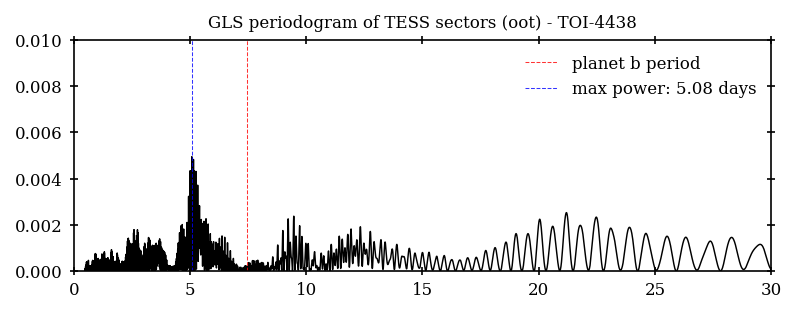

In [29]:
# first remove in-transit points
lslc = ls(time[~in_transit], flux[~in_transit], flux_err[~in_transit])

lc_freq, lc_power = lslc.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.7)
ax.set_xlim(0,30)
ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.5, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title(f'GLS periodogram of TESS sectors (oot) - {star_name}')
plt.savefig(f'./plots/toi4438/tess_oot_gls_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

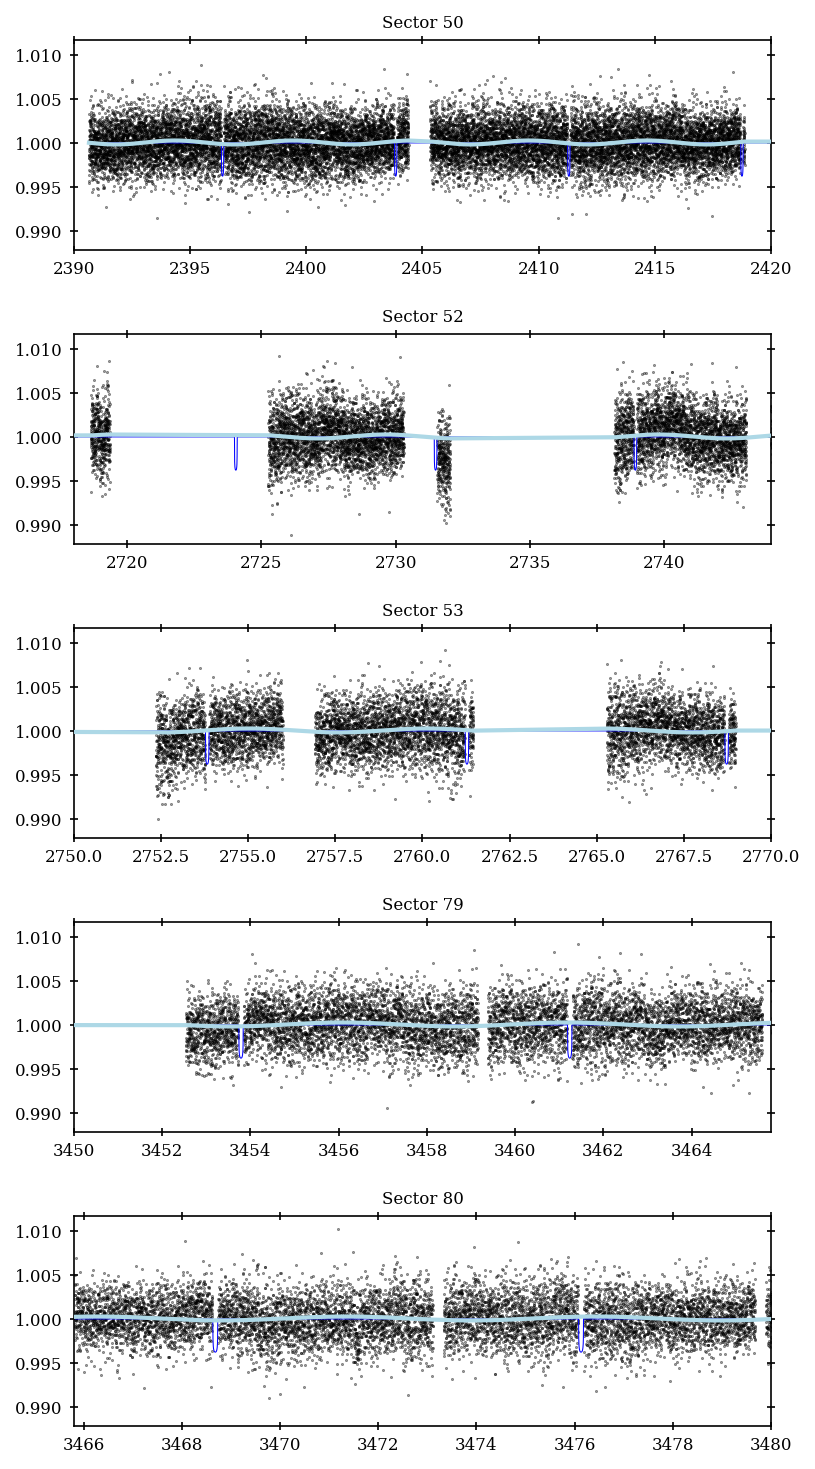

In [30]:
y_fit = lslc.model(time[~in_transit], lc_freq[np.argmax(lc_power)])
fig, ax = plt.subplots(5, 1, figsize=(6,12), dpi=150)
fig.subplots_adjust(hspace=0.4)
ax[0].plot(time[~in_transit], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[0].set_xlim(2390,2420)
ax[0].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[0].set_title('Sector 50')
ax[0].plot(results['model_lightcurve_time'], results['model_lightcurve_model'], color='b', linewidth=0.5)

ax[1].plot(time[~in_transit], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[1].set_xlim(2718,2744)
ax[1].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[1].set_title('Sector 52')
ax[1].plot(results['model_lightcurve_time'], results['model_lightcurve_model'], color='b', linewidth=0.5)

ax[2].plot(time[~in_transit], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[2].set_xlim(2750, 2770)
ax[2].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[2].set_title('Sector 53')
ax[2].plot(results['model_lightcurve_time'], results['model_lightcurve_model'], color='b', linewidth=0.5)

ax[3].plot(time[~in_transit], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[3].set_xlim(3450,3465.8)
ax[3].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[3].set_title('Sector 79')
ax[3].plot(results['model_lightcurve_time'], results['model_lightcurve_model'], color='b', linewidth=0.5)

ax[4].plot(time[~in_transit], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[4].set_xlim(3465.8,3480)
ax[4].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[4].set_title('Sector 80')
ax[4].plot(results['model_lightcurve_time'], results['model_lightcurve_model'], color='b', linewidth=0.5)


#plt.savefig(f'./plots/toi4438/tess-modulation_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [31]:
# compare rms of residuals and rms of data
rms_data = np.std(flux[~in_transit])
rms_res = np.std(flux[~in_transit] - y_fit)
print(rms_data*1e3, rms_res*1e3)

2.285685827836587 2.279599236315992


## Modelo

In [32]:
def get_xy(time_exp, version='short'):
    # parametros
    # ----------
    # time_exp: '120', '300' (int)
    # devuelve
    # ----------
    # x, y, yerr, texp (en días y ppt)
    if version == 'all':
        if time_exp == 120:
            t_ = time
            flux_ = flux
            flux_err_ = flux_err
            texp_ = texp
            id_ = sector_id
        elif time_exp == 300:
            t_ = time_5min
            flux_ = flux_5min
            flux_err_ = flux_err_5min
            texp_ = texp_binned
            id_ = sector_id_5min
    elif version == '1day':
        if time_exp == 120:
            t_ = time[intransit]
            flux_ = flux[intransit]
            flux_err_ = flux_err[intransit]
            texp_ = texp
            id_ = sector_id[intransit]
        elif time_exp == 300:
            t_ = time_5min[intransit_5min]
            flux_ = flux_5min[intransit_5min]
            flux_err_ = flux_err_5min[intransit_5min]
            texp_ = texp_binned
            id_ = sector_id_5min[intransit_5min]
    elif version == 'no-transits':
        if time_exp == 120:
            t_ = time[~intransit_small]
            flux_ = flux[~intransit_small]
            flux_err_ = flux_err[~intransit_small]
            texp_ = texp
            id_ = sector_id[~intransit_small]
        elif time_exp == 300:
            t_ = time_5min[~intransit_5min_small]
            flux_ = flux_5min[~intransit_5min_small]
            flux_err_ = flux_err_5min[~intransit_5min_small]
            texp_ = texp_binned
            id_ = sector_id_5min[~intransit_5min_small]


    x_ = np.ascontiguousarray(t_ - ref_time, dtype=np.float64)
    y_ = np.ascontiguousarray(1e3 * (flux_ - 1.0), dtype=np.float64) # Here we convert flux to ppt
    yerr_ = np.ascontiguousarray(1e3 * flux_err_, dtype=np.float64) 
    return x_, y_, yerr_, texp_, id_

## GP in LC

In [33]:
# lc para modelo

# 5-min lc
# x_, y_, yerr_, texp_, id_ = get_xy(300, 'no-transits')
# x_c, y_c, yerr_c, texp_c, id_c = get_xy(300, 'all')
# print(len(x_), len(x_c))

# 2-min lc
x_, y_, yerr_, texp_, id_ = get_xy(120, 'no-transits')
x_c, y_c, yerr_c, texp_c, id_c = get_xy(120, 'all')
print(len(x_), len(x_c))

72199 73600


In [34]:
# Prior analysis of noise GP on full 5-min LC to get the priors for joint model
with pm.Model() as model_lcgp:
    # LC jitter & GP parameters
    sigma_lc_ = pm.Uniform("sigma_lc_", lower=0, upper=10)
    rho_gp_ = pm.Uniform("rho_gp_", lower=0, upper=10)
    sigma_gp_ = pm.Uniform("sigma_gp_", lower=0, upper=10)

    kernel = terms.SHOTerm(
        sigma=sigma_gp_,
        rho=rho_gp_,
        Q=1 / np.sqrt(2))
    
    err_lc = pt.sqrt(yerr_**2 + sigma_lc_**2)
    gp_lc = GaussianProcess(kernel, t=x_, mean=0.0, yerr=sigma_lc_)
    gp_lc.marginal("obs_lc", observed=y_)
    pm.Deterministic("gp_lc_pred", gp_lc.predict(y_))
    pm.Deterministic("gp_lc_pred_complete", gp_lc.predict(y_, t=x_c))
    
    map_soln_tess = pm.find_MAP()

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


Output()

In [35]:
for key, value in map_soln_tess.items():
    if 'pred' not in key and 'interval' not in key:
        print(key,'= ', f'{value:.3f}')

timescale = map_soln_tess['rho_gp_']/(np.sqrt(2)*np.pi)
print(f'timescale = {timescale:.3f}')

sigma_lc_ =  2.238
rho_gp_ =  2.458
sigma_gp_ =  0.538
timescale = 0.553


In [36]:
# sigma_lc_ =  2.238
# rho_gp_ =  2.458
# sigma_gp_ =  0.538
# timescale = 0.553

(1060.0, 1100.0)

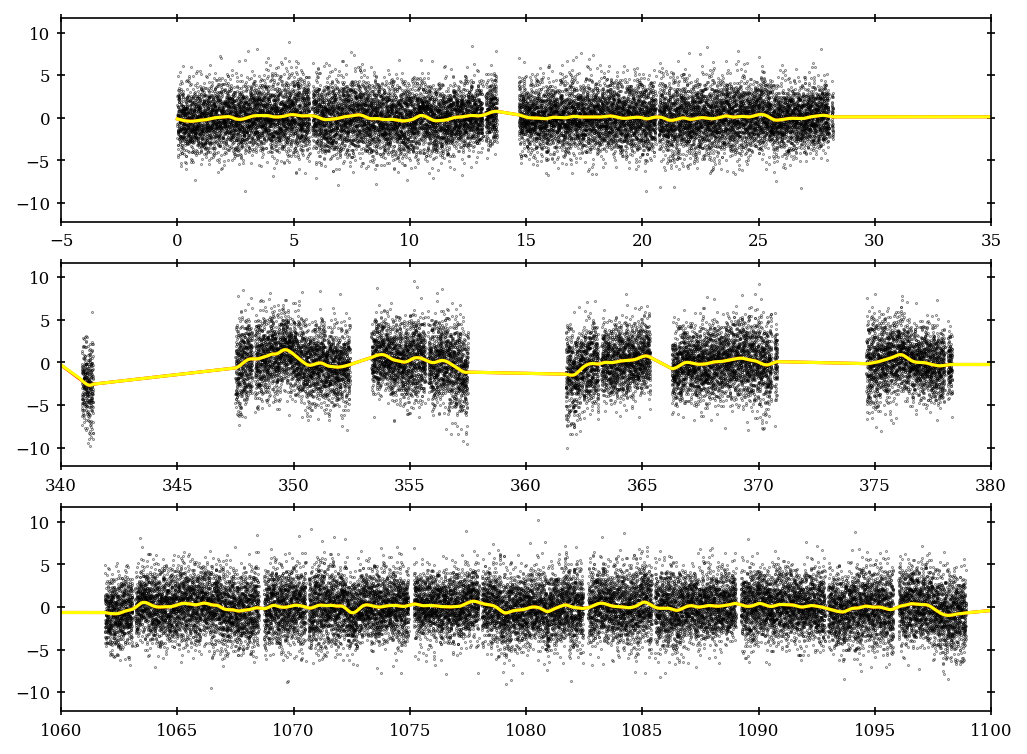

In [36]:
fig, axs = plt.subplots(len(sector_id_names), 1, figsize=(8, 6), dpi=150)
gp = map_soln_tess['gp_lc_pred']
gp_complete = map_soln_tess['gp_lc_pred_complete']

for i, name in enumerate(sector_id_names):
    ax = axs[i]
    # first plot the lc model with GP
    ax.plot(x_, y_, ".k", ms=0.4, label=f'{name}')
    ax.plot(x_, gp, label="gp model {}".format(name), color='red')
    ax.plot(x_c, gp_complete, label='gp complete', color='yellow')
axs[0].set_xlim(-5,35)
axs[1].set_xlim(340,380)
axs[2].set_xlim(1060,1100)

In [37]:
# since we don't need uncertainties, sampling serves no purpose here
# it's better to just optimize with MAP and get the point estimate of maximum likelihood

# with model_lcgp:
#     trace_gp_tess = pm.sample(
#         tune=250,
#         draws=500,
#         initvals=map_soln_tess,
#         target_accept=0.95,
#         init="adapt_full",
#         chains=4,
#         random_seed=42,
#         )

In [38]:
# # trace to save
# # az.to_netcdf(trace_gp_tess, './saves/toi4438/trace_lcgp_sho_1gp.save') 

# # save to trace
# trace_gp_tess = az.from_netcdf('./saves/toi4438/trace_lcgp_sho_1gp.save')

In [39]:
# flat_samps_gptess = trace_gp_tess.posterior.stack(sample=("chain", "draw"))

In [40]:
# fig, axs = plt.subplots(len(sector_id_names), 1, figsize=(8, 6), dpi=150)
# gp = flat_samps_gptess['gp_lc_pred'].median(axis=-1).values
# gp_complete = flat_samps_gptess['gp_lc_pred_complete'].median(axis=-1).values

# for i, name in enumerate(sector_id_names):
#     ax = axs[i]
#     # first plot the lc model with GP
#     ax.plot(x_, y_, ".k", ms=0.4, label=f'{name}')
#     ax.plot(x_, gp, label="gp model {}".format(name), color='red')
#     ax.plot(x_c, gp_complete, label='gp complete', color='yellow')
# axs[0].set_xlim(-5,35)
# axs[1].set_xlim(340,380)
# axs[2].set_xlim(1060,1100)

In [41]:
# vars_gp_tess = ['rho_gp_', 'sigma_gp_', 'sigma_lc_']

# summary = az.summary(trace_gp_tess, stat_funcs={'median': np.median, 'std':np.std}, 
#                      hdi_prob=0.68, round_to=6, stat_focus='median', var_names=vars_gp_tess)
# summary

In [42]:
# # # # traceplot
# az.plot_trace(trace_gp_tess, compact=True, var_names=vars_gp_tess)
# plt.subplots_adjust(hspace=0.5)
# plt.show()

In [43]:
params_gptess = {}
with open(f'./results/toi4438/gp_lc_tess_2min.txt', 'w') as f:
    for var, value in map_soln_tess.items():
        if 'pred' not in var and 'interval' not in var:
            f.write(f'{var} = {value:.6f}\n')
            print(var, " = {r:.6f}".format(r=value))
            if 'rho' in var:
                timescale = value/(np.sqrt(2)*np.pi)
                print(f'timescale = {timescale:.3f}')
                f.write(f'timescale = {timescale:.3f}\n')

f.close()              

sigma_lc_  = 2.238348
rho_gp_  = 2.458251
timescale = 0.553
sigma_gp_  = 0.537852


## Detrend and save LC

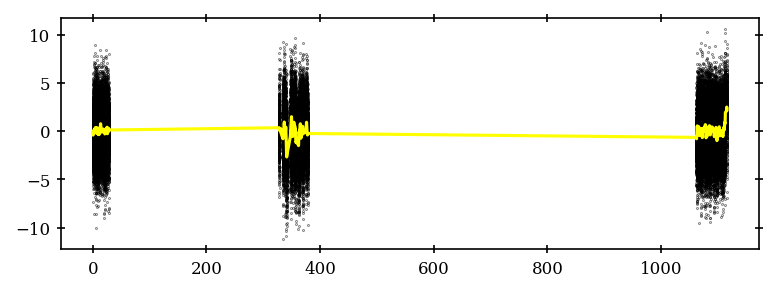

In [44]:
plt.figure(figsize=(6, 2), dpi=150)
plt.plot(x_c, gp_complete, label='gp complete', color='yellow', zorder=100)
plt.plot(x_c, y_c, ".k", ms=0.4, label='data')

2.3280711811896455
2.276689832148366


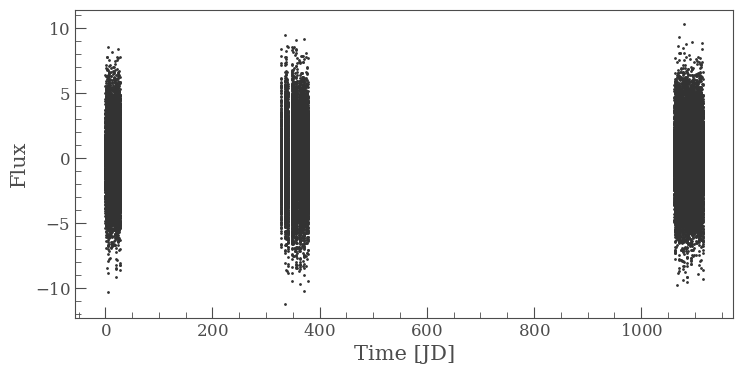

In [45]:
detrended_lc = lk.LightCurve(time=x_c, flux=y_c-gp_complete, flux_err=yerr_c)
detrended_lc.scatter()
print(np.std(y_c))
print(np.std(y_c-gp_complete))

In [47]:
# save
#detrended_lc.to_csv('./data/toi4438/detrended_lc_2min.csv', overwrite=True)

In [48]:
# # save gp predictions
# gp_lc = lk.LightCurve(time=x_c, flux=gp_complete)
# gp_lc.to_csv('./data/toi4438/gp_lc_2min.csv', overwrite=True)

# New transit

In [46]:
# read gp predictions
read_gp_4438 = pd.read_csv('./data/toi4438/gp_lc_2min.csv')
gplc_4438 = lk.LightCurve(time=read_gp_4438['time']+np.min(time), flux=read_gp_4438['flux'])
# read detrended lc
read_detrended_4438 = pd.read_csv('./data/toi4438/detrended_lc_2min.csv')
detrended_lc_4438 = lk.LightCurve(time=read_detrended_4438['time']+np.min(time), 
                                    flux=read_detrended_4438['flux'], 
                                    flux_err=read_detrended_4438['flux_err'])


(3465.28, 3480.88)

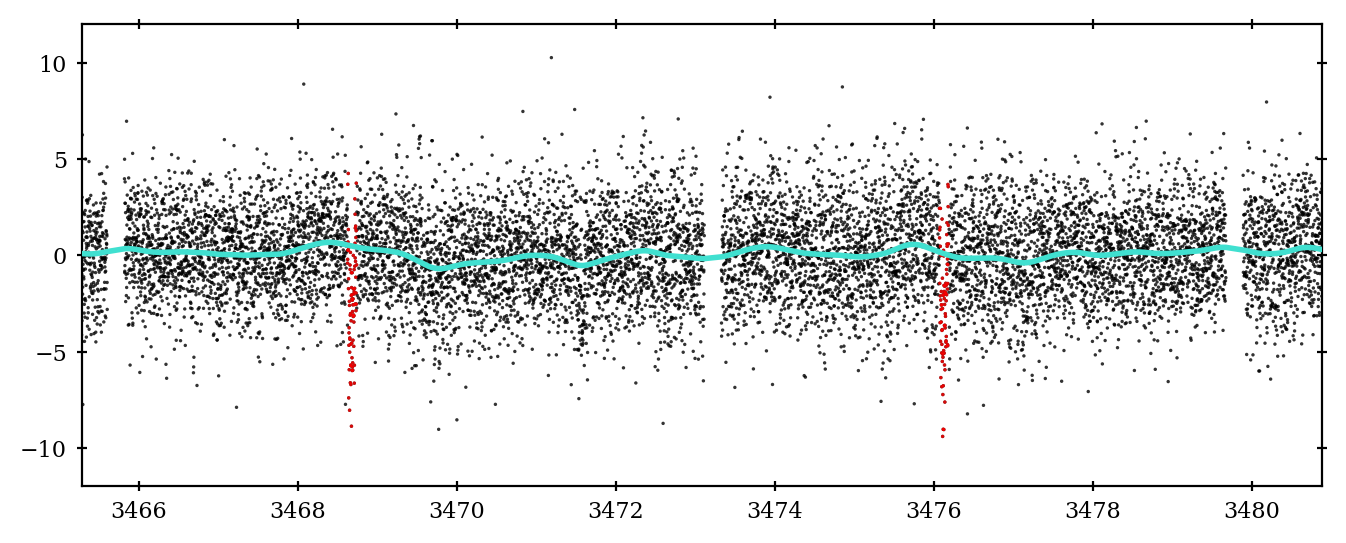

In [47]:
plt.figure(figsize=(8, 3), dpi=200)
plt.scatter(x_c+np.min(time), y_c, s=6, color='k', marker='.', edgecolors='none', alpha=0.8, zorder=20)
plt.scatter(x_c[in_transit]+np.min(time), y_c[in_transit], s=6, color='red', marker='.', edgecolors='none', alpha=0.8, zorder=20)
plt.plot(gplc_4438.time.value, gplc_4438.flux.value, c="turquoise", zorder=100, lw=2)
plt.ylim(-12, 12)
plt.xlim(3465.28, 3480.88)
# plt.savefig('plots/toi4438/tls/other_transit_.png', dpi=300, bbox_inches='tight')

# Model the new transit

<ErrorbarContainer object of 3 artists>

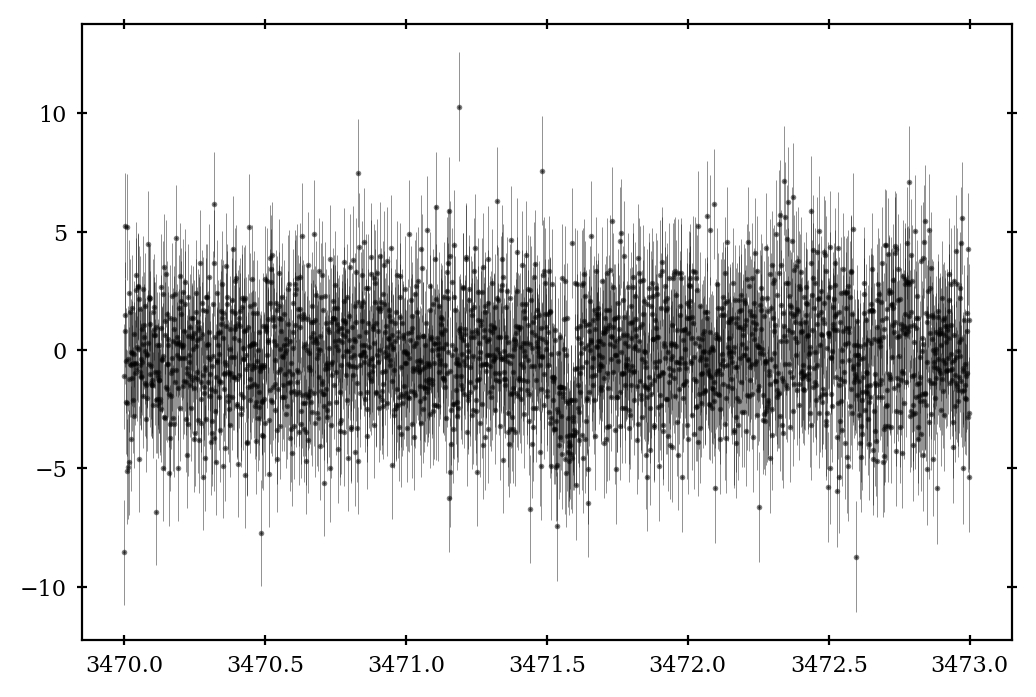

In [48]:
t_ = np.ascontiguousarray(x_c + np.min(time), dtype=np.float64)
y_ = np.ascontiguousarray(y_c, dtype=np.float64)
yerr_ = np.ascontiguousarray(yerr_c, dtype=np.float64)

new_mask = (t_ < 3473) & (t_ > 3470)
t_ = t_[new_mask]
y_ = y_[new_mask]
yerr_ = yerr_[new_mask]

plt.errorbar(t_, y_, yerr=yerr_, fmt='o', color='black', markersize=1, elinewidth=0.3, alpha=0.5, label='Data')

## BLS

In [49]:
from astropy.timeseries import BoxLeastSquares

In [50]:
bls = BoxLeastSquares(t_, y_, yerr_)
durations = np.linspace(0.01, 0.3, 100)  # durations in days
bls_power = bls.power(np.array([10]), durations, oversample=20)

In [51]:
bls_model = bls.model(t_, bls_power.period, bls_power.duration, bls_power.transit_time)

(3471.45, 3471.7)

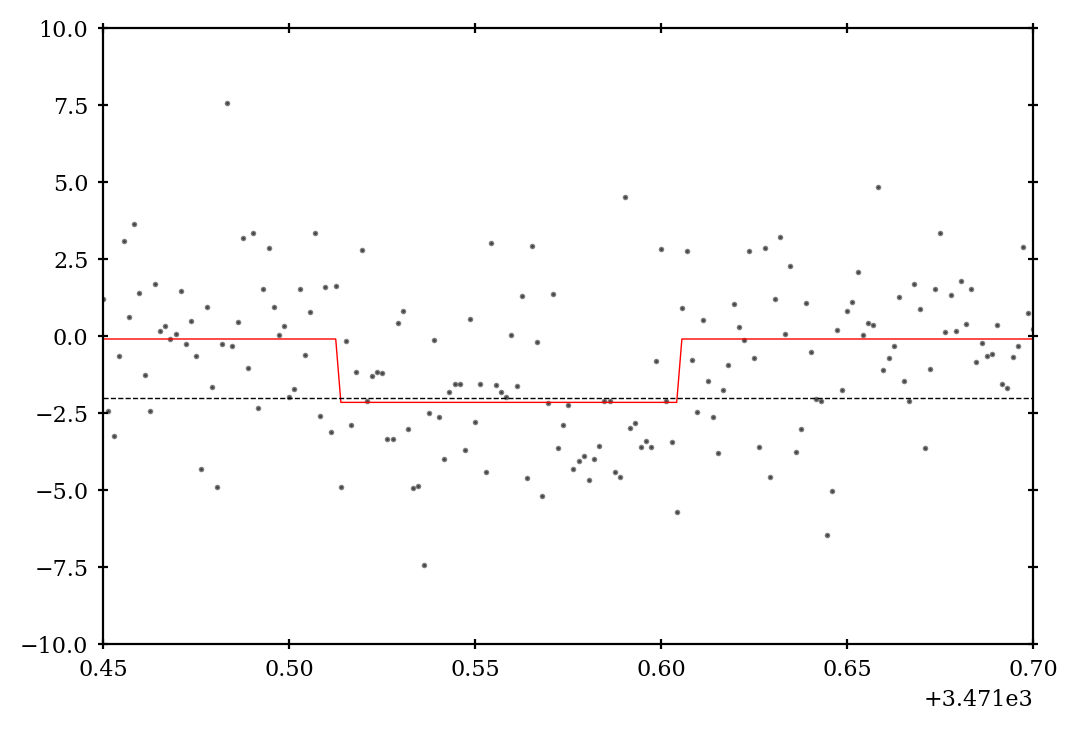

In [52]:
plt.scatter(t_, y_, s=1, color='k', alpha=0.5, label='Data')
plt.plot(t_, bls_model, color='red', lw=0.5, label='BLS Model')
plt.axhline(-2., color='black', lw=0.5, ls='--')
plt.ylim(-10,10)
plt.xlim(3471.45, 3471.7)

In [56]:
r_star = 0.36
ror = np.sqrt(bls_power.depth*1e-3)[0]
r_pl = ror*r_star*u.R_sun.to(u.R_earth)  # convert to Earth radii
depth = bls_power.depth[0]  # in ppt
depth_err = bls_power.depth_err[0]  # in ppt
duration = (bls_power.duration*24)[0]  # convert to hours
time_of_transit = bls_power.transit_time[0]
print(f'ror: {ror:.3f}')
print(f'r_pl:, {r_pl:.3f}, earth radii')
print(f'depth: {depth:.3f} ppt')
print(f'depth error: {depth_err:.3f} ppt')
print(f'duration: {duration:.3f} h')
print(f'time of transit: {time_of_transit:.4f}     BJD-2,457,000')
with open(f'./results/toi4438/new_transit.txt', 'w') as f:
    f.write(f'ror: {ror:.3f}\n')
    f.write(f'r_pl: {r_pl:.3f} Earth radii\n')
    f.write(f'depth: {depth:.3f} ppt\n')
    f.write(f'duration: {duration:.3f} h\n')
    f.write(f'time of transit: {time_of_transit:.4f} BJD-2,457,000\n')
f.close()

ror: 0.045
r_pl:, 1.781, earth radii
depth: 2.057 ppt
depth error: 0.288 ppt
duration: 2.208 h
time of transit: 3471.5591     BJD-2,457,000
